# Advanced Financial Statistics Coursework

### Ho Yeung Pak (01866980)
### Zihan Zhou (01712075)
### Chris Meimaridis (02480429)
### Farhad Huseynli (02476796)

In [1]:
### Importing Required Libraries

import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import scipy.stats as stats
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.diagnostic import acorr_ljungbox
import yfinance as yf

## Q1

The file **USMacro_Quarterly** contains quarterly data on several macroeconomic time series for the United States. The variable PCED is the price index for personal consumption expenditures from the U.S. National Income and Product Accounts (the Personal Consumption Expenditures Deflator). In this exercise, we will construct forecasting models for the rate of inflation based on PCED. For this analysis, we use the sample period 1963:Q1-2017:Q4 (where data before 1963 may be used, as necessary, as initial values for lags in regressions).

<font color=green>

**ai.)** Compute the inflation rate $Inf = 400 x [ln(PCED_{t}-ln(PCED_{t-1}]$ What are the units of **Inf**? (Is **Inf** measured in dollars, percentage points, percentage per quarter, percentage per year, or something else? Explain). 
    
<font>

In [2]:
#ai

macro_quarterly = pd.read_excel('us_macro_quarterly1.xlsx', index_col = 0)
macro_quarterly['Inf'] =  400 * (np.log(macro_quarterly['PCED']) - np.log(macro_quarterly['PCED'].shift(1)))
macro_quarterly.tail(5)

,GDPC1,JAPAN_IP,PCED,CPI,Inf
freq,,,,,
2016-10-01,16851.420,99.125073,111.583,242.177333,1.972899
2017-01-01,16903.240,99.291726,112.198,243.949000,2.198584
2017-04-01,17031.085,101.324890,112.273,244.010000,0.267295
2017-07-01,17163.894,101.724856,112.699,245.296667,1.514857
2017-10-01,17271.702,103.491376,113.458,247.301333,2.684871


**Written answer**

**Inf** is measured as a percentage per year, because the first difference of log (multiplies with 100) is approximately equal to the percentage change of a time series data. For this case that will be equivalent to a percentage per quarter. However, we are multiplying the log difference with 400 instead, this will be equivalent to a percentage per year.


$ln(x) \approx ln(1) + (x-1)\frac{d}{dx}lnx|_{x = 1} = x - 1$

$100(ln(x_t) - ln(x_{t-1})) = 100 ln(\frac{x_t}{x_{t-1}}) \approx 100 (\frac{x_t}{x_{t-1}}-1)$ =  percentage change per quarter

$400(ln(x_t) - ln(x_{t-1})) = 400 ln(\frac{x_t}{x_{t-1}})  \approx (\frac{x_t}{x_{t-1}}-1)$ =  percentage change per year

<font color = green>

**aii.)** Plot the value of **Inf** from 1963:Q1 through 2017:Q4. Based on the plot, do you think that **Inf** has a stochastic trend? Explain. 
    
<font>

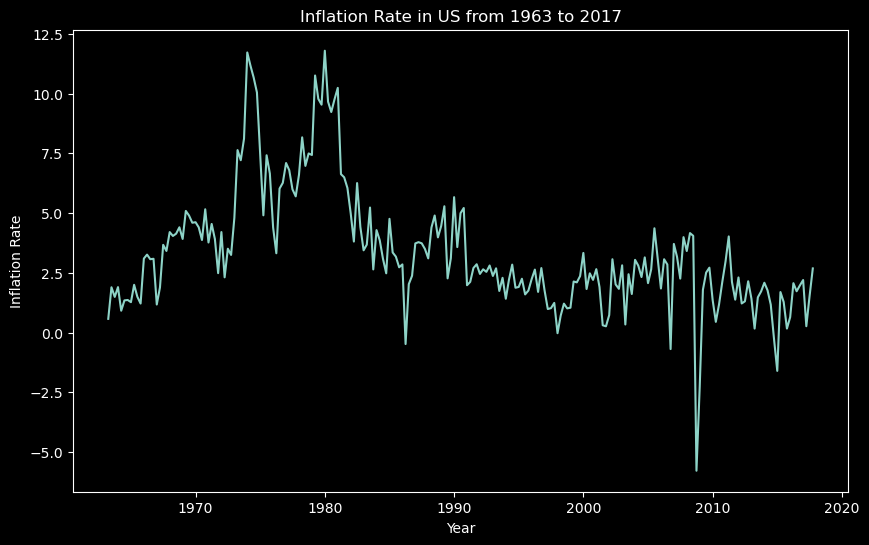

In [3]:
#aii

plt.figure(figsize = (10,6))
plt.plot(macro_quarterly[macro_quarterly.index > "1963-01-01"]['Inf'])
plt.title("Inflation Rate in US from 1963 to 2017")
plt.xlabel("Year")
plt.ylabel("Inflation Rate")
plt.show()

**Written Answer**

Based on the graph, the inflation rate may exhibit a stochastic trend, as we can see the inflation rate is somewhat sticky, i.e. it will maintain a similar value for a long period, and there is not any deterministic trend. From the 1960s to the 1970s, it has had an upward trend. In the 1980s, it had a downward trend. While starting from 1990, the inflation rate sticks around 2.5% for a long period.

The stickiness of the inflation rate tells us that the inflation rate may follow a stochastic trend.

However, further test has to be performed to check whether the movement can be explained by other factors.

<font color = green>
    
**bi.)** Compute the first four autocorrelations of $\Delta Inf$

<font>

In [4]:
#bi

macro_quarterly['delta inf'] = macro_quarterly['Inf'] - macro_quarterly['Inf'].shift(1)

In [5]:
delta_inf = macro_quarterly['delta inf']

In [6]:
dataframe = pd.concat([delta_inf, delta_inf.shift(1), delta_inf.shift(2), delta_inf.shift(3), delta_inf.shift(4)], axis =1)

In [7]:
dataframe.columns = ["delta_inf_lag_{}".format(i) for i in range(0,5)]

dataframe_filtered = dataframe[dataframe.index >= '1963-01-01']

correlation_matrix = dataframe_filtered.corr()

In [8]:
print("The first autocorrelation is:...", round(correlation_matrix.iloc[0,1],3))
print("The second autocorrelation is:...", round(correlation_matrix.iloc[0,2],3))
print("The third autocorrelation is:...", round(correlation_matrix.iloc[0,3],3))
print("The fourth autocorrelation is:...", round(correlation_matrix.iloc[0,4],3))

The first autocorrelation is:... -0.246
The second autocorrelation is:... -0.204
The third autocorrelation is:... 0.138
The fourth autocorrelation is:... -0.086


<font color = green>
    
**bii.)** Plot the value of $\Delta Inf$ from 1963:Q1 through 2017:Q4 Explain why the behaviour of $\Delta Inf$ in the plot is consistent with the first order autocorrelation that you computed in (i)
    
<font>

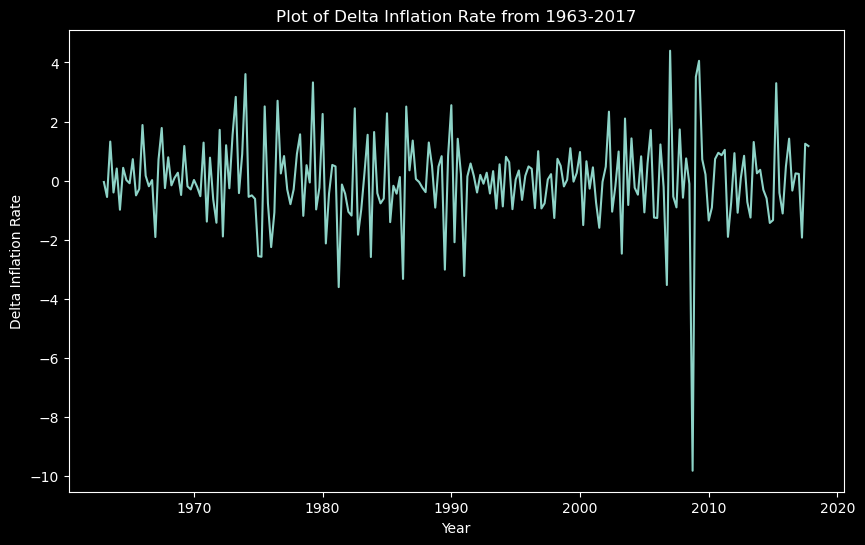

In [9]:
#bii

plt.figure(figsize = (10,6))
plt.plot(dataframe_filtered['delta_inf_lag_0'])
plt.title("Plot of Delta Inflation Rate from 1963-2017")
plt.xlabel("Year")
plt.ylabel("Delta Inflation Rate")
plt.show()

**Written Answer**

The first order autocorrelation we computed in (i) is negative. The graph above also supports our finding because it shows the alternating pattern of the $\Delta Inf$ (one positive value is usually followed by a negative value).

<font color = green>

**ci.)** . i. Run an OLS regression of $\Delta Inf_t$ on $\Delta Inf_{t-1}$ on . Does knowing the change in inflation over the current quarter help predict the change in inflation over the next quarter?
Explain.
    
<font>

In [10]:
#1ci

Y = dataframe_filtered['delta_inf_lag_0']
x = dataframe_filtered['delta_inf_lag_1']
x = sm.add_constant(x)

model_1 = sm.OLS(Y,x)

result_1 = model_1.fit()
print(result_1.summary())

                            OLS Regression Results                            
Dep. Variable:        delta_inf_lag_0   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     14.08
Date:                Fri, 14 Jun 2024   Prob (F-statistic):           0.000224
Time:                        11:48:05   Log-Likelihood:                -391.13
No. Observations:                 220   AIC:                             786.3
Df Residuals:                     218   BIC:                             793.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0074      0.097     

**Written Answer**

Knowing the change in inflation over the current quarter does help predict the change in inflation over the next quarter, as we can see the p-value of our regression coefficient is nearly 0.

<font color = green>
    
**cii.)** . Estimate an AR(2) model for $\Delta Inf$. Is the AR(2) model better than an AR(1) model? Explain.     
    
<font>

In [11]:
#cii

Y = dataframe_filtered['delta_inf_lag_0']
x = dataframe_filtered[['delta_inf_lag_1', 'delta_inf_lag_2']]
x = sm.add_constant(x)

model_2 = sm.OLS(Y,x)

result_2 = model_2.fit()
print(result_2.summary())

                            OLS Regression Results                            
Dep. Variable:        delta_inf_lag_0   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     17.09
Date:                Fri, 14 Jun 2024   Prob (F-statistic):           1.28e-07
Time:                        11:48:05   Log-Likelihood:                -381.92
No. Observations:                 220   AIC:                             769.8
Df Residuals:                     217   BIC:                             780.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0061      0.093     

**Written Answer**

Given that the AR(2) model has a larger Adjusted R-squared and lower Information Criteria, both AIC and BIC, compared with the AR(1) model. We conclude the AR(2) model is better than the AR(1) model in terms of explaning the variance in $\Delta Inf$.

<font color = green>
    
**ciii.)** Estimate an AR(p) model for p=0, 1, …, 8. What lag length is chosen by the BIC? What lag length is chosen by the AIC? 
    
<font>

In [12]:
#ciii

AIC = []
BIC = []


for p in range(1, 10):
    
    regression_data = pd.concat([delta_inf.shift(i) for i in range(p)], axis=1)
    regression_data.columns = ["delta_inf_lag_{}".format(i) for i in range(p)]
    
    
    regression_data_filtered = regression_data[regression_data.index >= '1963-01-01']
    
    
    Y = regression_data_filtered['delta_inf_lag_0']
    X = regression_data_filtered.drop('delta_inf_lag_0', axis=1)
    X = sm.add_constant(X)
    
    
    model = sm.OLS(Y, X)
    result = model.fit()
    
    
    AIC.append(result.aic)
    BIC.append(result.bic)

In [13]:
AIC_table = pd.DataFrame(AIC, columns = ['AIC'])
print(AIC_table)

          AIC
0  798.025868
1  786.253194
2  769.846110
3  771.840386
4  770.972957
5  769.698199
6  769.731372
7  771.668997
8  773.370288


In [14]:
BIC_table = pd.DataFrame(BIC, columns = ['BIC'])
print(BIC_table)

          BIC
0  801.419495
1  793.040450
2  780.026992
3  785.414896
4  787.941095
5  790.059964
6  793.486765
7  798.818017
8  803.912936


**Written Answer**

The lag length chosen by AIC is 5, while the lag length chose by BIC is 2.

<font color = green>
    
**civ.)**  Use the AR(2) model to predict the change in inflation from 2017:Q4 to 2018:Q1 – that is, to predict the value of $\Delta Inf_{2018:Q1}$.
    
<font>

In [15]:
# civ

change_in_inflation = result_2.params[0]+ result_2.params[1]*delta_inf[-1] + result_2.params[2]* delta_inf[-2]

In [16]:
print("predicted change in inflation in 2018 Q1", change_in_inflation)

predicted change in inflation in 2018 Q1 -0.7205222412628434


<font color = green>
    
**cv.)** Use the AR(2) model to predict the level of the inflation rate in 2018:Q1 – that is, $Inf_{2018:Q1}$    

<font>

In [17]:
# cv

print("predicted level of inflation in 2018 Q1", macro_quarterly['Inf'][-1]+ change_in_inflation)

predicted level of inflation in 2018 Q1 1.9643483561361261


<font color =green>
    
**di.)** Use the ADF test for the regression $$\Delta Inf_t = \beta_0 + \delta Inf_{t-1} + \gamma_{1} \Delta Inf_{t-1} + \gamma_{2} Inf_{t-2} + u_t$$

with two lags of **Inf** to test for a stochastic trend in **Inf**    
    
<font>

In [18]:
# di
from statsmodels.tsa.stattools import adfuller


def adf_test(timeseries, regression, autolag, maxlag):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag= autolag, maxlag = maxlag, regression = regression)
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [19]:
adf_test(macro_quarterly[macro_quarterly.index >= "1963-01-01"]['Inf'], regression='c', autolag=None, maxlag= 2)

Results of Dickey-Fuller Test:
Test Statistic                  -2.715760
p-value                          0.071351
#Lags Used                       2.000000
Number of Observations Used    217.000000
Critical Value (1%)             -3.460849
Critical Value (5%)             -2.874953
Critical Value (10%)            -2.573919
dtype: float64


<font color = green>
    
**dii.)** Is the ADF test based on equation (1) preferred to the test based on ADF regression with time trend, e.g., on the ADF regression
$$\Delta Inf_t = \beta_0 +\alpha t+ \delta Inf_{t-1} + \gamma_{1} \Delta Inf_{t-1} + \gamma_{2} Inf_{t-2} + u_t$$
Explain.
    
<font>

**Written Answer**

The ADF test based on equation (1) is preferred to the test based on ADF regression with time trend. It is because, from our plot and previous analysis. There is no observable trend that is determined by the time element. Therefore, if we include the time trend in our ADF regression, this can lead to wrong p-value test statistics for our ADF regression test.

<font color = green>

**diii.)** In (i), you used two lags of $\Delta Inf$. Should you used more lags? Fewer lags? Explain.   
    
<font>

**Written Answer**

I think two lags of $\Delta Inf$ are suitable. Given that 2 lags is the lag length chosen by Bayes Information Criteria. More lags may lead the estimate of $\delta$ bias towards zero and fewer lags may make the model overestimate the significance of the $Inf_{t-1}$ term.

<font color = green>
    
**div.)** Based on the test you carried out in (i), does the AR model for Inf contain a unit root? Explain carefully. (Hint: Does the failure to reject a null hypothesis mean that the null hypothesis is true?)
    
<font>

**Written Answer**

Based on the test we carried out in (i), we cannot reject the null hypothesis that the AR model for Inf contains a unit root. Therefore, we have evidence that the AR time series is non-stationary. However, we can't conclude the AR model for Inf must have a unit root, further tests like KPSS should be carried out to validate our findings.

<font color = green>
    
**e.)** Use the QLR test with 15% trimming to test the stability of the coefficients in the AR(2) model for $\Delta Inf$.	Is the AR(2) model stable? Explain.     
    
    
<font>

In [20]:
# e

def qlrtest(Y,X,trim_point = 0.15):
    
    n = len(Y)
    trim = int(n * trim_point)
    
    
    qlr_stat = 0.0
    
    for tau in range(trim + 1, n - trim):
        Y1, x1 = Y[:tau] , x.iloc[:tau,]
        Y2, x2 = Y[tau:], x.iloc[tau:,]
        
        model_full = sm.OLS(Y, x)
        model_a = sm.OLS(Y1, x1)
        model_b = sm.OLS(Y2, x2)
        
        result_full = model_full.fit()
        result_a = model_a.fit()
        result_b = model_b.fit()
        
        rss_full = result_full.ssr
        rss_a = result_a.ssr
        rss_b = result_b.ssr
        
        k = X.shape[1]
        
        numerator = (rss_full - (rss_a + rss_b)) / (k)
        denominator = (rss_a + rss_b) / (n - 2 * (k))
        F_stat = numerator / denominator
        
        qlr_stat = max(F_stat, qlr_stat)
        
    return qlr_stat

In [21]:
qlrtest(dataframe_filtered['delta_inf_lag_0'], sm.add_constant(dataframe_filtered[['delta_inf_lag_1','delta_inf_lag_2']]))

2.538702529789547

**Written Answer**

The Quandt Likelihood Ratio is smaller than the 10% critical value in QLR test with 3 restrictions, we conclude that we have evidence that the AR(2) model is stable

## Question 2

In the data file `USMacro_Monthly`, you will find data on two aggregate price series for the United States: the Consumer Price Index (CPI) and the Personal Consumption Expenditures Deflator (PCED). These series are alternative measures of consumer prices in the United States. The CPI prices a basket of goods whose composition is updated every 5-10 years. The PCED uses chain-weighting to price a basket of goods whose composition changes from month to month. Economists have argued that CPI will overstate inflation because it does not take into account the substitution that occurs when relative prices change. If this substitution bias is important, then average CPI inflation should be systematically higher than that PCED inflation. Let

$$
\pi_{CPI,t} = 1200 \times \ln \left( \frac{CPI_t}{CPI_{t-1}} \right), \quad \pi_{PCED,t} = 1200 \times \ln \left( \frac{PCED_t}{PCED_{t-1}} \right)
$$

and

$$
Y_t = \pi_{CPI,t} - \pi_{PCED,t}
$$

so that $\pi_{CPI,t}$ is the monthly rate of price inflation (measured in percentage points at an annual rate) based on the CPI, $\pi_{PCED,t}$ is the monthly rate of price inflation from the PCED, and $Y_t$ is the difference. Using data from 1959:1 through 2004:12, carry out the following exercises.

Consider the “constant-term-only” regression

$$
Y_t = \mu + u_t, \quad t=1, \ldots, T.
$$


### (a) 

Do you think $u_t$ is serially correlated? Explain.

Inference on $\mu$ in model (1) under heteroskedasticity and autocorrelation in $u_t$ is usually based on the t-statistic

$$
t_Y = \frac{\bar{Y} - \mu_0}{\hat{\omega}/\sqrt{T}},
$$

where $\mu_0$ is a hypothesized value of $\mu$, $\bar{Y} = \frac{1}{T} \sum_{t=1}^T Y_t$ is the sample mean and $\hat{\omega}^2$ is an estimator of the long-run variance $\omega^2 = \lim_{T \to \infty} \text{Var}(\sqrt{T} \bar{Y})$ of $\bar{Y}$.

1. Construct a 95% confidence interval for $\mu$ using Newey-West HAC standard errors with $\omega^2$ estimated by

$$
\hat{\omega}^2 = \hat{\gamma}(0) + 2 \sum_{h=1}^{b(T)} \hat{\gamma}(h) \left(1 - \frac{h}{b(T)}\right),
$$

where $\hat{\gamma}(h)$ are sample autocovariances, $k(z) = 1 - z$ for $0 \leq z \leq 1$, $k(z) = 0$ for $z > 1$, and $b = b(T)$ is the HAC bandwidth parameter. What value of the HAC bandwidth parameter $b$ did you choose? Why? Is there statistically significant evidence that the mean inflation rate for the CPI is greater than the rate for the PCED?

In [22]:
# Load the data from the Excel file
data = pd.read_excel('us_macro_monthly1.xlsx', parse_dates=['freq'])
# Set the 'freq' column as the index
data.set_index('freq', inplace=True)
print(data)

                CPI  EXUSUK  FEDFUNDS   GS1  GS10    INDPRO     PCED  TB3MS  \
freq                                                                          
1955-01-01   26.770     NaN      1.39  1.39  2.61   19.9437      NaN   1.22   
1955-02-01   26.820     NaN      1.29  1.57  2.65   20.1941      NaN   1.17   
1955-03-01   26.790     NaN      1.35  1.59  2.68   20.6669      NaN   1.28   
1955-04-01   26.790     NaN      1.43  1.75  2.75   20.9173      NaN   1.59   
1955-05-01   26.770     NaN      1.43  1.90  2.76   21.2510      NaN   1.45   
...             ...     ...       ...   ...   ...       ...      ...    ...   
2017-08-01  245.262  1.2952      1.16  1.23  2.21  104.5605  112.629   1.01   
2017-09-01  246.392  1.3340      1.15  1.28  2.20  104.8195  113.077   1.03   
2017-10-01  246.583  1.3202      1.15  1.40  2.36  106.5818  113.247   1.07   
2017-11-01  247.411  1.3217      1.16  1.56  2.35  106.8643  113.481   1.23   
2017-12-01  247.910  1.3404      1.30  1.70  2.40  1

In [23]:
# Ensure the index is in datetime format
data.index = pd.to_datetime(data.index)

# Filter data from 1959:1 to 2004:12
start_date = '1959-01-01'
end_date = '2004-12-31'
data = data.loc[start_date:end_date]

# Calculate monthly inflation rates for CPI and PCED
data['pi_t_CPI'] = 1200 * np.log(data['CPI'] / data['CPI'].shift(1))
data['pi_t_PCED'] = 1200 * np.log(data['PCED'] / data['PCED'].shift(1))

# Calculate the difference y_t
data['y_t'] = data['pi_t_CPI'] - data['pi_t_PCED']

# Drop missing values resulting from the shift operation
data = data.dropna()

# Display the first few rows to confirm the calculations
print(data[['pi_t_CPI', 'pi_t_PCED', 'y_t']].head())

            pi_t_CPI  pi_t_PCED       y_t
freq                                     
1959-02-01 -0.413722   0.980678 -1.394400
1959-03-01 -1.242022   0.769971 -2.011993
1959-04-01  0.414150   2.376792 -1.962642
1959-05-01  2.481904   0.558562  1.923342
1959-06-01  2.889081   3.415529 -0.526448


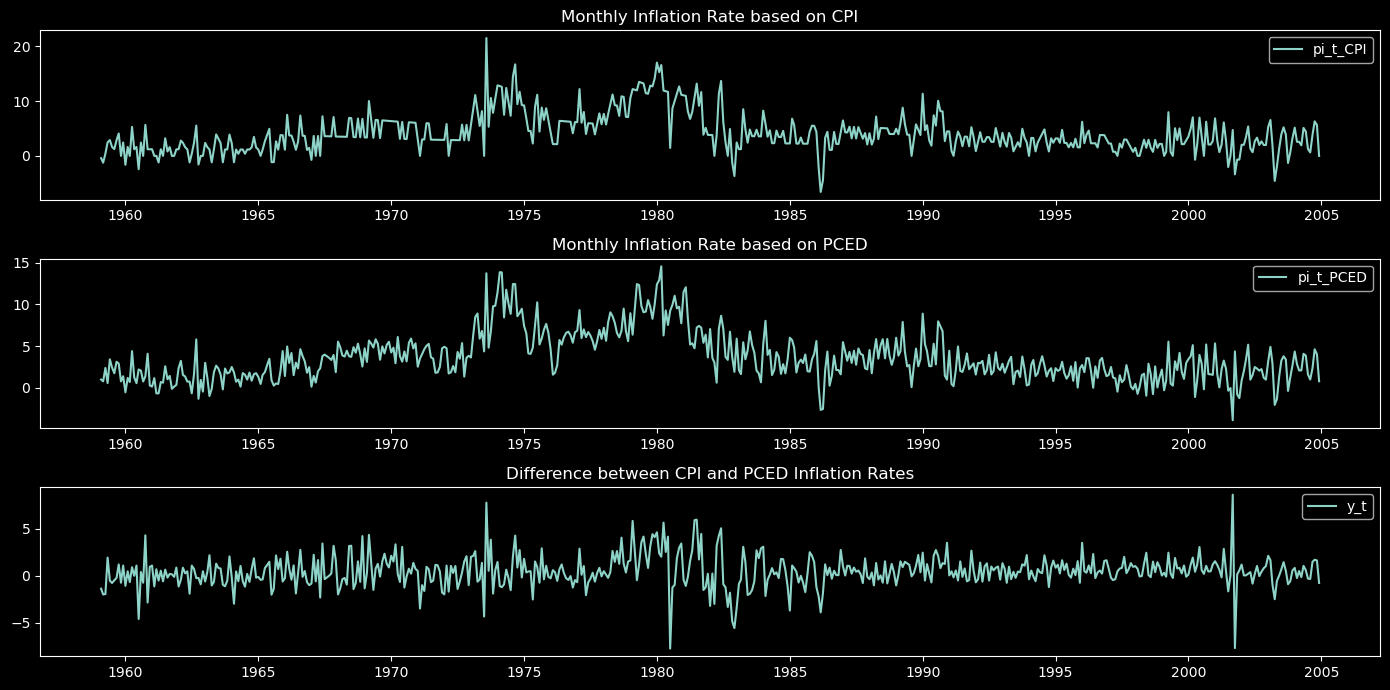

In [24]:
# Plot the inflation rates and their difference
plt.figure(figsize=(14, 7))

plt.subplot(3, 1, 1)
plt.plot(data.index, data['pi_t_CPI'], label='pi_t_CPI')
plt.title('Monthly Inflation Rate based on CPI')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(data.index, data['pi_t_PCED'], label='pi_t_PCED')
plt.title('Monthly Inflation Rate based on PCED')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(data.index, data['y_t'], label='y_t')
plt.title('Difference between CPI and PCED Inflation Rates')
plt.legend()

plt.tight_layout()
plt.show()

Durbin-Watson statistic: 1.7412734928110412


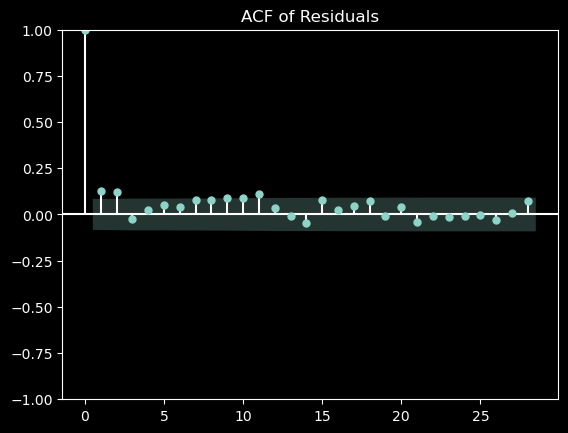

In [25]:
# Run the regression Y_t = mu + u_t
X = np.ones(len(data))  # This is just the intercept term (mu)
y = data['y_t']
model = sm.OLS(y, X).fit()

# Calculate the residuals
residuals = model.resid

# Perform the Durbin-Watson test
dw_stat = durbin_watson(residuals)
print(f'Durbin-Watson statistic: {dw_stat}')

# Plot the autocorrelation function of the residuals
plot_acf(residuals)
plt.title('ACF of Residuals')
plt.show()

In [26]:
def bartlett_kernel(h, b):
    return 1 - h / b if h <= b else 0

def sample_autocovariance(series, h):
    n = len(series)
    mean = np.mean(series)
    autocov = np.sum((series[:n-h] - mean) * (series[h:] - mean)) / n
    return autocov

def newey_west_variance(series, b_T):
    n = len(series)
    gamma_0 = sample_autocovariance(series, 0)
    long_run_variance = gamma_0
    
    for h in range(1, b_T + 1):
        gamma_h = sample_autocovariance(series, h)
        long_run_variance += 2 * bartlett_kernel(h, b_T) * gamma_h
        
    return long_run_variance

def hac_standard_error(series, b_T):
    n = len(series)
    long_run_variance = newey_west_variance(series, b_T)
    return np.sqrt(long_run_variance / n)

In [27]:
T = len(y)
bandwidth = int(0.75*T**(1/3))
series_y = pd.Series(y)
omega_hat = np.sqrt(newey_west_variance(series=series_y, b_T=bandwidth))
hac_se = hac_standard_error(series = series_y, b_T= bandwidth)
print(f"Omega hat: {omega_hat}")
print(f"HAC standard error: {hac_se}")

Omega hat: 4.120717813675944
HAC standard error: 0.17554848090173808


In [28]:
mu_0 = 0
t_stats = np.sqrt(T)*(np.mean(y)-mu_0)/omega_hat
print(f"t_stats: {t_stats}")

# Calculate the sample mean
sample_mean = np.mean(y)
# Determine the critical value from the t-distribution
n = len(y)
critical_value = stats.t.ppf(0.95, df=n-1)  # 0.975 for 95% confidence interval


# Calculate the upper bound of the one-sided confidence interval
upper_bound = sample_mean + critical_value * hac_se

# Print the results
print(f"Sample mean: {sample_mean}")
print(f"HAC standard error: {hac_se}")
print(f"One-sided 95% confidence interval: (-∞, {upper_bound}]")

t_stats: 2.7316802785898577
Sample mean: 0.47954232321568624
HAC standard error: 0.17554848090173808
One-sided 95% confidence interval: (-∞, 0.7687810591492183]


### (b) 

State the assumptions that guarantee consistency of the standard errors you used in part (a) and discuss whether they are likely to hold in this exercise.

The Newey-West HAC standard errors are consistent under the following assumptions:

1.	Stationarity: The time series data is stationary, meaning its statistical properties such as mean and variance do not change over time.
2.	Weak Dependence: The time series exhibits weak dependence, implying that distant observations are nearly independent. This is typically formalized as the series having short memory.
3.	Finite Variance: The variance of the time series is finite.
4.	Homoskedasticity and Autocorrelation Consistency: The estimator accounts for potential heteroskedasticity (changing variance) and autocorrelation (correlation between observations at different times).
5.	Sufficient Lag Length: The chosen lag length b(T) for the Bartlett kernel is appropriate and increases with the sample size, ensuring that the autocovariances up to the chosen lag length are correctly estimated.

1.	Stationarity:
•	Likely to Hold: Inflation rates, especially in a stable economy, can often be treated as stationary over long periods, particularly after detrending and differencing if necessary. In this context, CPI and PCED inflation rates, calculated as percentage changes, might be assumed stationary after such preprocessing.
2.	Weak Dependence:
•	Likely to Hold: Monthly inflation rates tend to exhibit weak dependence since macroeconomic shocks and policy changes have diminishing effects over time. Hence, the assumption of weak dependence is reasonable.
3.	Finite Variance:
•	Likely to Hold: Economic data, including inflation rates, typically exhibit finite variance, though outliers and structural breaks (such as financial crises) might temporarily affect this. However, in a long-term analysis, this assumption generally holds.
4.	Homoskedasticity and Autocorrelation Consistency:
•	Accounted for by Newey-West: The Newey-West estimator is specifically designed to handle heteroskedasticity and autocorrelation, making this assumption less stringent. It adjusts the standard errors to be consistent in the presence of such issues.
5.	Sufficient Lag Length:
•	Likely to Hold: b(T) was chosen to be T-1 as stated in equation (2)

### (c) 

Let $X_t, t=1, \ldots, q, q \geq 2$, be independent mean-zero normal $N(\mu, \sigma_t^2)$ random variables with common mean $\mu = E(X_t)$ and variances $\sigma_t^2 = \text{Var}(X_t)$. Consider the usual t-statistic for the hypothesis test $H_0: \mu = 0$ against $H_a: \mu > 0$ given by

$$
t_X = \frac{\bar{X}_q}{s_X / \sqrt{q}},
$$

where $\bar{X}_q = \frac{1}{q} \sum_{t=1}^q X_t$ is the sample mean and $s_X^2 = \frac{1}{q-1} \sum_{i=1}^q (X_i - \bar{X}_q)^2$ is the sample variance of $X_t, t=1, \ldots, q$. As discussed in Ibragimov and Müller (2007) (see Theorem 1 in that paper and the discussion following it), the one-sided t-test using $t_X$ is conservative in the following sense:

Let $T_{q-1}$ denote a random variable that has Student-t distribution with $q-1$ degrees of freedom. Further, let $cv_q(\alpha)$ be the critical value of the usual one-sided t-test based on $t_X$ of level $\alpha$, that is, $P(T_{q-1} > cv_q(\alpha)) = \alpha$. Then, if $2 \leq q \leq 14$ and $\alpha \leq 0.05$, then

$$
\sup_{\sigma_1^2, \ldots, \sigma_q^2} P\left(t_X > cv_q(\alpha)\right) \leq \alpha.
$$

Further, relation (2) holds for all $q \geq 2$ if $\alpha \leq \Phi^{-1}(0.04163)$.

The t-statistic based approach to asymptotic inference in Ibragimov and Müller (2010) can thus be used to test $H_0: \mu = 0$ against $H_a: \mu > 0$ in model (1). One first divides the data into $q$ blocks and estimates the sample means $\bar{Y}^{(s)}$ using the data in each of the blocks $s=1, \ldots, q$. Then the statistic $t(\bar{Y}^{(1)}, \ldots, \bar{Y}^{(q)})$ is formed using the estimators and the null hypothesis is rejected in favor of the alternative for large positive values of $t(\bar{Y}^{(1)}, \ldots, \bar{Y}^{(q)})$ (see Ibragimov and Müller (2010) for further discussion). Relation (3) implies that the procedure results in asymptotically correct inference as long as the significance level $\alpha \leq \Phi^{-1}(0.04163)$ for $q \geq 14$ and $\alpha \leq 0.05$ for $2 \leq q \leq 14$ and, under $H_0$,

$$
T\left(\bar{Y}^{(1)}, \ldots, \bar{Y}^{(q)}\right) \Rightarrow \left(Z_1, \ldots, Z_q\right)
$$

where $Z_i, i=1, \ldots, q,$ are independent normal $N(0, \omega_i^2)$ random variables with possibly different limit variances $\omega_i^2$. The approach is thus robust to, for instance, changes in the long-run variance of $Y_t$. By conditioning, it can also be used in the case of convergence to mixtures of normals with stochastic $\omega_i^2$ which is important, for instance, in the analysis of heavy-tailed models and stochastic volatility and conditional heteroskedasticity models.

1. Apply the t-statistic based approach described to test $H_0: \mu = 0$ against $H_a: \mu > 0$ in model (1) and compare your results to those in part (a).

In [29]:
# Divide the data into q blocks
def divide_into_blocks(series, q):
    n = len(series)
    block_size = n // q
    blocks = [series[i * block_size:(i + 1) * block_size] for i in range(q)]
    return blocks


# Perform the test for q = 4 blocks
q = 4
print(f"Performing test for q = {q} blocks:")

# Divide the data into q blocks
blocks = divide_into_blocks(series_y, q)


# Initialize lists to store omega_hat and t_stats
omega_hats = []
t_stats_list = []

for i, block in enumerate(blocks):
    T = len(block)
    bandwidth = int(0.75*T**(1/3))
    series_y = pd.Series(block)
    
    omega_hat = np.sqrt(newey_west_variance(series=series_y, b_T=bandwidth))
    hac_se = hac_standard_error(series=series_y, b_T=bandwidth)
    
    t_stat = np.sqrt(T) * (np.mean(series_y) - 0) / omega_hat
    
    omega_hats.append(omega_hat)
    t_stats_list.append(t_stat)
    
    print(f"Block {i+1}:")
    print(f"Omega hat: {omega_hat}")
    print(f"HAC standard error: {hac_se}")
    print(f"t-statistic: {t_stat}")

Performing test for q = 4 blocks:
Block 1:
Omega hat: 2.5514552510314132
HAC standard error: 0.21798553320403288
t-statistic: 1.1313229817961643
Block 2:
Omega hat: 3.629437766098021
HAC standard error: 0.3100837948672258
t-statistic: 2.6094677557296673
Block 3:
Omega hat: 2.8699506511958175
HAC standard error: 0.24519643161183516
t-statistic: 1.0926294968400807
Block 4:
Omega hat: 2.2989739320536806
HAC standard error: 0.19641459837412745
t-statistic: 2.9860995535752495


In [30]:
# Estimate sample means for each block
def calculate_block_means(blocks):
    block_means = np.array([np.mean(block) for block in blocks])
    return block_means

# Form the test statistic
def t_statistic_for_blocks(block_means):
    q = len(block_means)
    mean_of_means = np.mean(block_means)
    std_of_means = np.std(block_means, ddof=1)
    t_stat = mean_of_means / (std_of_means / np.sqrt(q))
    return t_stat

# Calculate block means
block_means = calculate_block_means(blocks)

# Calculate the t-statistic
t_stat = t_statistic_for_blocks(block_means)

# Step 4: Compare the t-statistic to the critical value
critical_value = stats.t.ppf(0.95, df=q-1)  # One-tailed test for 95% confidence level

# Print the results
print(f"Block means: {block_means}")
print(f"t-statistic: {t_stat}")
print(f"Critical value (one-tailed, 95% confidence): {critical_value}")

# Decision based on the t-statistic
if t_stat > critical_value:
    print("Reject the null hypothesis H0: mu = 0 in favor of Ha: mu > 0")
else:
    print("Fail to reject the null hypothesis H0: mu = 0")

Block means: [0.24661204 0.80915366 0.26790885 0.58651354]
t-statistic: 3.53402751596055
Critical value (one-tailed, 95% confidence): 2.353363434801826
Reject the null hypothesis H0: mu = 0 in favor of Ha: mu > 0


### (d) 

Discuss your choices for the number of blocks $q$ in part (c). Discuss whether the assumptions for asymptotic validity of the t-statistic based procedure are likely to be satisfied in the exercise.

**Reference**

Ibragimov, R. and Müller, U. (2010). t-statistic based correlation and heterogeneity robust inference. Journal of Business and Economic Statistics 28, 453-468.

The Durbin-Watson statistic of 1.656 suggests there is some positive autocorrelation present in the residuals, though it is not very strong since the value is reasonably close to 2. The initial spike at lag 1 is relatively high but within the confidence interval, indicating some autocorrelation but not excessively strong.
Subsequent lags mostly fall within the confidence intervals, suggesting that the residuals are not strongly autocorrelated at these lags.

Bandwidth parameter b was chosen to be $0.75T^{1/3}$.
There is no statistically significant evidence that the the mean inflation rate for the CPI is greater than the rate for the PCED.

The t-stats based approach shows statistically significant evidence that the the mean inflation rate for the CPI is greater than the rate for the PCED. This result differs the results from (a).

Choice of  q = 4 

•	Justification: The choice of  q = 4  balances the need for multiple blocks to estimate variability and ensuring each block contains enough observations to be reliable.
•	Impact: This choice aims to provide a reliable estimate of the t-statistics by averaging over multiple blocks, reducing the impact of any single block’s anomalies.

Assumptions for Asymptotic Validity

•	Independence Across Blocks: Likely to hold due to non-overlapping blocks.
•	Stationarity: Assumed to hold within each block for short-term stationarity.
•	Finite Variance: Reasonable for most economic data.
•	Sufficient Block Size: With small sample sizes, this is a trade-off, but  q = 4  aims to balance it.

## Q3

In [31]:
#Download SPX data from yfinance
data = yf.download("^GSPC", start = "2000-01-01",end = "2024-05-28")
data.drop(["Open","High","Low","Close","Volume"], axis = 1, inplace = True)

[*********************100%%**********************]  1 of 1 completed


In [32]:
data

,Adj Close
Date,
2000-01-03,1455.219971
2000-01-04,1399.420044
2000-01-05,1402.109985
2000-01-06,1403.449951
2000-01-07,1441.469971
...,...
2024-05-20,5308.129883
2024-05-21,5321.410156
2024-05-22,5307.009766


In [33]:
#Calculate the dailiy average return for the SPX price
data["Adj Close shifted"] = data["Adj Close"].shift(1)
data.dropna()
data["returns"] = np.log(data["Adj Close shifted"]) - np.log(data["Adj Close"])
data

,Adj Close,Adj Close shifted,returns
Date,,,
2000-01-03,1455.219971,NaN,NaN
2000-01-04,1399.420044,1455.219971,0.039099
2000-01-05,1402.109985,1399.420044,-0.001920
2000-01-06,1403.449951,1402.109985,-0.000955
2000-01-07,1441.469971,1403.449951,-0.026730
...,...,...,...
2024-05-20,5308.129883,5303.270020,-0.000916
2024-05-21,5321.410156,5308.129883,-0.002499
2024-05-22,5307.009766,5321.410156,0.002710


**Tail index ζ** is a metric that demonstrates how heavy the tail of the underlying distribution is. The smaller the tail is, the higher the probability of observing "outliers" or large fluctuations in the underlying returns.

Typically, the tail index is considered to lie between the interval of 2<ζ<4 for developed markets, which means that there exists some form of non-normality in the data, with the third and fourth moments of the distribution being infinite.

Bellow we can demostrate the tail index in the form of a power law:

$
\
P(|r| > x) \sim \frac{C}{x^{\zeta}}, x > 0 
\
$

**Hills Maximum Likelihood estimator - Hills MLE** is one of the most well know methods that one can apply in order to estimate the tail index ζ.

It is a semi - parametric tail index estimator that approximates the top n order statistics with a Pareto distribution and estimates the tail index z using a Maximum Likelihood estimation (MLE) approach.

If we consider a sample of $r_1, r_2, \ldots, r_N$  returns, that follow a power law, with tail index Z, then our first step is to 

$|r_{(1)}| \geq |r_{(2)}| \geq \ldots \geq |r_{(n)}| \geq |r_{(n+1)}|$
                                                     

where $|r_{(j)}|$ is the largest absolute returns ordered in a decreasing order. The typical tail truncation level, is chosen as a fraction of the sample N, such as 5% or 10%.

The Hill's estimator $\hat{\zeta}_{\text{Hill}} $ of ζ concerning is:

$
\
\hat{\zeta}_{\text{Hill}} = \frac{n}{\sum_{t=1}^{n} \left( \log |r_{(t)}| - \log |r_{(n+1)}| \right)}
\
$

with a standard error of 

$
\
\text{s.e.}_{\text{Hill}} = \frac{1}{\sqrt{n}} \hat{\zeta}_{\text{Hill}}
\
$

One may determine a 95% confidence interval by:

$
\
95\% \text{CI}_{\text{Hill}} = \left( \hat{\zeta}_{\text{Hill}} - \frac{1.96}{\sqrt{n}} \hat{\zeta}_{\text{Hill}}, \hat{\zeta}_{\text{Hill}} + \frac{1.96}{\sqrt{n}} \hat{\zeta}_{\text{Hill}} \right)
\
$

In [34]:
#Define a function that estimates Hill's Estimator for tail index
def Hill_MLE(df,k):
    df.dropna(inplace = True)
    df_sorted = sorted(np.abs(df), reverse = True)
    
    a = 0
    for i in range(k-1):
        param = np.log(df_sorted[i]) - np.log(df_sorted[k])
        a += param

    hill_estimator_value = k/a
    
    #standard error of Hill's estimator
    hill_se = np.sqrt(1/k)*hill_estimator_value
    
    #upper bound 95%
    up_bound_hill = hill_estimator_value + hill_se*1.96
    
    #lower bound 95%
    lower_bound_hill = hill_estimator_value - hill_se*1.96
    
    stats = {"Hills Estimator":hill_estimator_value, "Standard Error":hill_se, "Upper Bound":up_bound_hill,"Lower Bound":lower_bound_hill}
    return stats

In [35]:
#Use the Fixed Quantile Approach in order to estimate the proper value for k
k = int(len(data)*0.1)
hill = Hill_MLE(data["returns"],k) 
hill = pd.DataFrame(hill, index= [0])

In [36]:
hill

,Hills Estimator,Standard Error,Upper Bound,Lower Bound
0,2.522882,0.101898,2.722602,2.323161


While Hill's MLE estimator is a powerfull tool on it's own, it comes with some drawbacks. Specifically, it is well known that the standard errors obtained can be underestimated in cases of finite samples and dependent heterogeneous observations.

To address the above problems, several alternative methodologies have been developed to estimate the tail index. Running an OLS LLRS regression provides a solid method to estimate ζ. 

**OLS log log rank-size regression** is an alternative method to estimate the tail index ζ. The typical proceedure is to perform a typical OLS regression with a γ = 1/2 (based on Gabaix and Ibragimov (2011)).

$
\
\log(t - \gamma) = a - b \log |r_{(t)}|
\
$

The OLS estimator for the tail index ζ is the $
\hat{b}
$ from the above equation. The shift of 1/2 is optimal by decreasing bias in finite samples.

The standard error for the Hill's

$
\
\text{s.e.}_{\text{RS}} = \sqrt{\frac{2}{n}} \hat{\zeta}_{\text{RS}}
\
$

One may determine a 95% confidence interval by:

$
\
95\% \text{CI}_{\text{RS}} = \left( \hat{\zeta}_{\text{RS}} - 1.96 \times \sqrt{\frac{2}{n}} \hat{\zeta}_{\text{RS}}, \hat{\zeta}_{\text{RS}} + 1.96 \times \sqrt{\frac{2}{n}} \hat{\zeta}_{\text{RS}} \right)
\
$

In [37]:
#Define a function that estimates the tail index using LLRR
def LLRR(df,k):
    df.dropna(inplace = True)
    df_sorted = sorted(np.abs(df), reverse = True)
    
    #rank
    rank = np.arange(1,k+1)
    log_rank = np.log(rank-0.5)
    
    log_values = np.log(df_sorted[:k])
    log_values = sm.add_constant(log_values)
    
    model = sm.OLS(log_rank, log_values).fit()
    llrr_estimaro_value = -model.params[1]
    
    #standard error of LLRS estimator
    llrr_se = np.sqrt(2/k)*llrr_estimaro_value
    
    #upper bound 95%
    up_bound_llrr = llrr_estimaro_value + llrr_se*1.96
    
    #lower bound 95%
    lower_bound_llrr = llrr_estimaro_value - llrr_se*1.96
    
    stats = {"LLRR Estimator":llrr_estimaro_value, "Standard Error":llrr_se, "Upper Bound":up_bound_llrr,"Lower Bound":lower_bound_llrr}    
    
    return stats

In [38]:
#Use the Fixed Quantile Approach in order to estimate the proper value for k
k = int(len(data)*0.1)
llrr = LLRR(data["returns"],k) 
llrr = pd.DataFrame(llrr, index= [0])

In [39]:
llrr

,LLRR Estimator,Standard Error,Upper Bound,Lower Bound
0,2.858318,0.163266,3.178319,2.538317


**Results**

We can see that by using both the Hill's MLE and the OLS LLRR estimators for finding the tail index, we confirm the assumption of 2<ζ<4, which indicates a finite first and second moment of the distribution. On the other hand, we can also refer that there exist "fat tails" in the distribution, since the third and fourth moments are infinite, indicating to the existance of extreme values.